# Advanced Explorative Data Analysis
TODO: Text!

In [1]:
# Import necessary libraries
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")


In [2]:
# Import data and remove NaNs (races which weren't finished)
data = pd.read_csv("data/cleaned_data/races_cleaned.csv")
data[["race_created", "race_driven"]] = \
    data[["race_created", "race_driven"]].astype("datetime64")
data.dropna(inplace=True)


In [3]:
# Parameter
title_fontsize = 25
axis_fontsize = 20
legend_size = 20
tick_label_fontsize = 15


## 1 Fuel consumption
We have finally cleaned the data set, so how does it look like?

### 1.1 Distribution
how is it distributed?

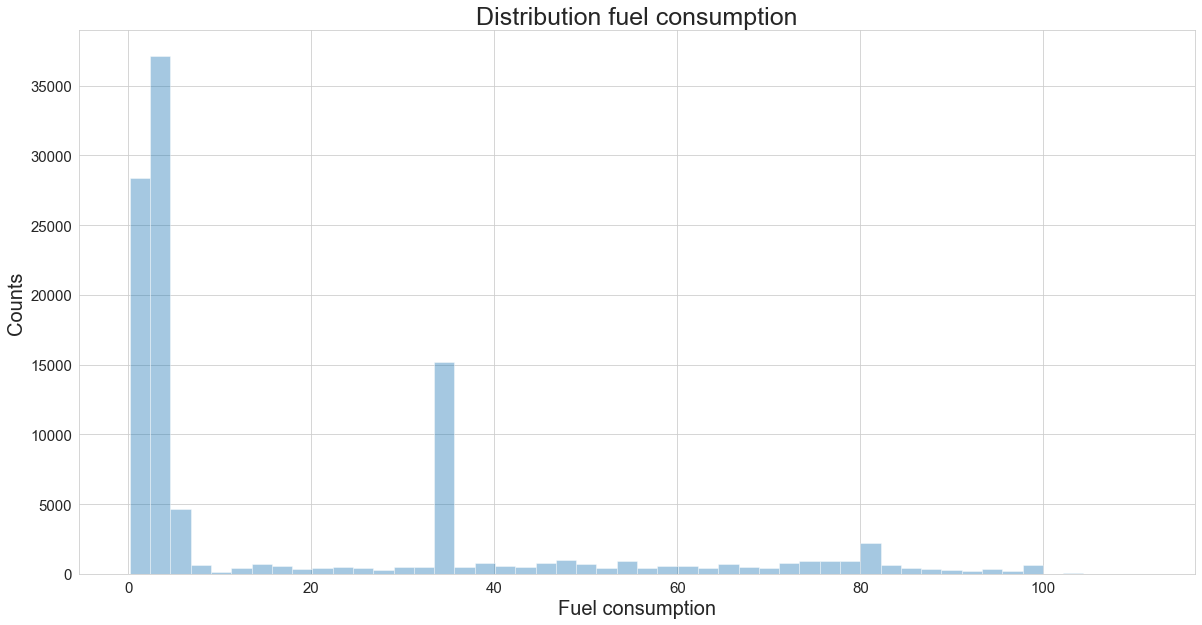

In [6]:
fig, ax = plt.subplots(figsize=(20, 10))

sns.distplot(data["fuel_consumption"], kde=False)
plt.title("Distribution fuel consumption", fontsize=title_fontsize)
plt.xlabel("Fuel consumption", fontsize=axis_fontsize)
plt.ylabel("Counts", fontsize=axis_fontsize)
ax.tick_params(axis="both", which="major", labelsize=15)

plt.show()

TODO: text: meist wenig fuel zweiter peak bei etwa 35

### 1.2 What effects fuel consumption?
Can we find some connections between different variables. In particular, for fuel consumption and money?

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(20, 10)) # TODO: plot schön!

sns.scatterplot(x="fuel_consumption", y="weather", data=data, ax=ax[0])
ax[0].set_title("Fuel consumption vs. weather", fontsize=title_fontsize)
ax[0].set_xlabel("Fuel consumption", fontsize=axis_fontsize)
ax[0].set_ylabel("Weather", fontsize=axis_fontsize)
ax[0].tick_params(axis="both", which="major", labelsize=15)
# seems to be no correlation between fuel and weather


sns.scatterplot(x="fuel_consumption", y="track_id", data=data, ax=ax[1])
ax[1].set_title("Fuel consumption vs. track", fontsize=title_fontsize)
ax[1].set_xlabel("Fuel consumption", fontsize=axis_fontsize)
ax[1].set_ylabel("Track", fontsize=axis_fontsize)
ax[1].tick_params(axis="both", which="major", labelsize=15)

fig.tight_layout()
plt.sho

Obviously no connection to track or weather. Thus, it remains unclear what affects fuel consumption. given that only one value it might be a condition on the race itself? otherwise you would also expect two values - opp/chal. However, without further information only speculation

## 2 Money
Are the high values correlated to something?

In [ ]:
df_money = data.loc[data.money>=200000]  # consider only high values of money

fig, ax = plt.subplots(2, 1, figsize=(20, 10)) # TODO: plot schön!

sns.scatterplot(x="money", y="fuel_consumption", data=df_money, ax=ax[0]) # no number of labs?
ax[0].set_title("High money vs. fuel consumption", fontsize=title_fontsize)
ax[0].set_xlabel("Money", fontsize=axis_fontsize)
ax[0].set_ylabel("Fuel consumption", fontsize=axis_fontsize)
ax[0].tick_params(axis="both", which="major", labelsize=15)


sns.scatterplot(x="money", y="weather", data=df_money, ax=ax[1]) # no conditions on track
ax[1].set_title("High money vs. weather", fontsize=title_fontsize)
ax[1].set_xlabel("Money", fontsize=axis_fontsize)
ax[1].set_ylabel("Weather", fontsize=axis_fontsize)
ax[1].tick_params(axis="both", which="major", labelsize=15)

fig.tight_layout()
plt.show()

most likely choosable by players? though still unclear why so many glatte low values..

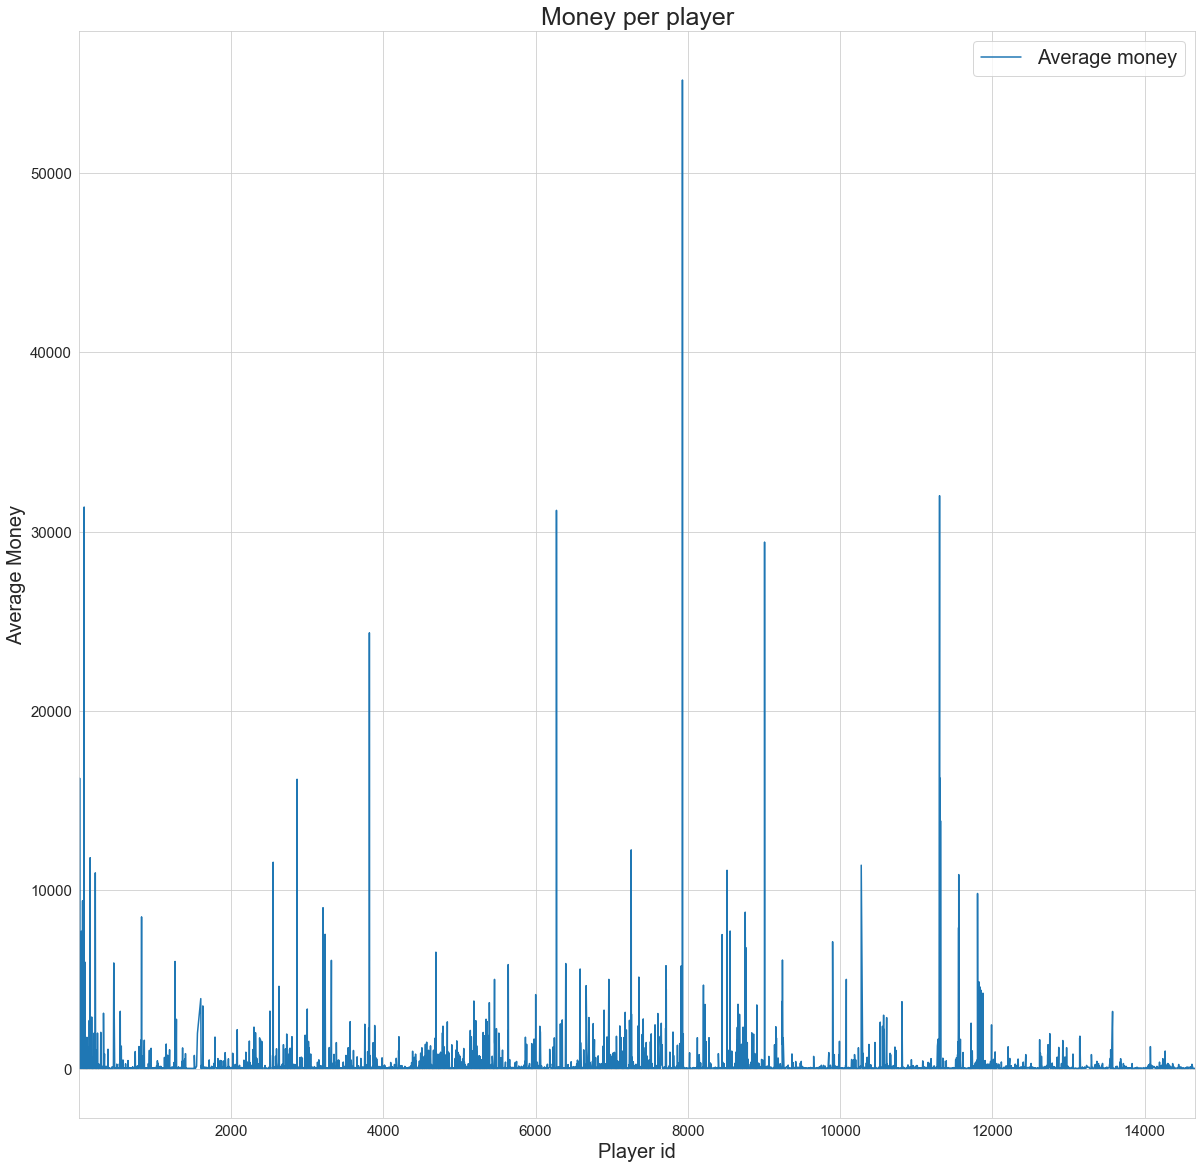

In [6]:
df_player = pd.DataFrame(data.groupby("challenger").mean()).reset_index()
df_player.rename(columns={"challenger": "player"}, inplace=True)
df_player = df_player[["player", "money"]]
df_player
df_opponent = pd.DataFrame(data.groupby("opponent").mean()).reset_index()
df_opponent.rename(columns={"opponent": "player"}, inplace=True)
df_opponent = df_opponent[["player", "money"]]
df_opponent
df_player = df_player.append(df_opponent).groupby("player").mean()
df_player = df_player.iloc[1:]  # remove first because that is when no race happened


fig, ax = plt.subplots(figsize=(20, 20))

df_player.plot(ax=ax)
plt.title("Money per player", fontsize=title_fontsize)
plt.xlabel("Player id", fontsize=axis_fontsize)
plt.ylabel("Average Money", fontsize=axis_fontsize)
ax.tick_params(axis="both", which="major", labelsize=tick_label_fontsize)
ax.legend(["Average money"], prop={"size": legend_size})

# TODO: plot anpassen! Title etc
plt.show()

Obvioulsy a few player quite rich. Most likely playerd against rich player?

## 3 Time
Can we find players with unusual time activity? might be different time zones?
we categorize stuff time of day TODO text!

In [27]:
# Auxiliary function
def categorize_time_of_day(hour):

    online_times = {"morning": list(range(6, 13)),
                    "afternoon": list(range(12, 18)),
                    "evening": list(range(17, 22)),
                    "early_night": list(range(21, 24)) + [0, 1],
                    "night": list(range(1, 7))}

    if hour in online_times["morning"]:
        return "morning"
    elif hour in online_times["afternoon"]:
        return "afternoon"
    elif hour in online_times["evening"]:
        return "evening"
    elif hour in online_times["early_night"]:
        return "early_night"
    elif hour in online_times["night"]:
        return "night"

In [17]:
# Extract hours per player
df_challenger = pd.DataFrame(data.groupby("challenger").apply(lambda x: x.race_driven.dt.strftime("%H"))).reset_index(level=1, drop=True)
df_challenger.index.names = ["player_id"]
df_challenger.rename(columns={"race_driven": "hour"}, inplace=True)

df_opponent = pd.DataFrame(data.groupby("opponent").apply(lambda x: x.race_driven.dt.strftime("%H")).reset_index(level=1, drop=True))
df_opponent.rename(columns={"race_driven": "hour"}, inplace=True)
df_opponent.index.names = ["player_id"]

df_player = df_challenger.append(df_opponent)

# Count hours per player
df_player = pd.DataFrame(df_player.reset_index().groupby("player_id")["hour"].value_counts())
df_player.rename(columns={"hour": "games_per_hour"}, inplace=True)
df_player.reset_index(level=1, inplace=True)
df_player["hour"] = df_player["hour"].astype("int")

# Categorize time of day
df_player["time_of_day"] = df_player["hour"].apply(lambda x: categorize_time_of_day(x))

# Remove all players with only one race
df_player["total_games"] = df_player.groupby("player_id")["games_per_hour"].sum()
df_player = df_player.loc[df_player.total_games > 1]

# Compute fraction
df_player["fraction_games_per_hour"] = (df_player.loc[:,"games_per_hour"]/df_player.loc[:,"total_games"]).values

# Get maximum category for each player
df_player_aux = df_player.groupby(["player_id","time_of_day"])["fraction_games_per_hour"].sum().reset_index(level=1)
index_max_time_of_day = df_player_aux.groupby(["player_id"])["fraction_games_per_hour"].transform(max) == df_player_aux["fraction_games_per_hour"]
max_time_of_day = df_player_aux[index_max_time_of_day]

# Map back to df_player dataframe # TODO: really crappy code!
time_of_days = df_player["time_of_day"].unique()
df_player["max_time_of_day"] = time_of_days[0]
for day_time in time_of_days[1:]:
    df_player.loc[max_time_of_day.loc[max_time_of_day.time_of_day==day_time].index.unique(), "max_time_of_day"] = day_time

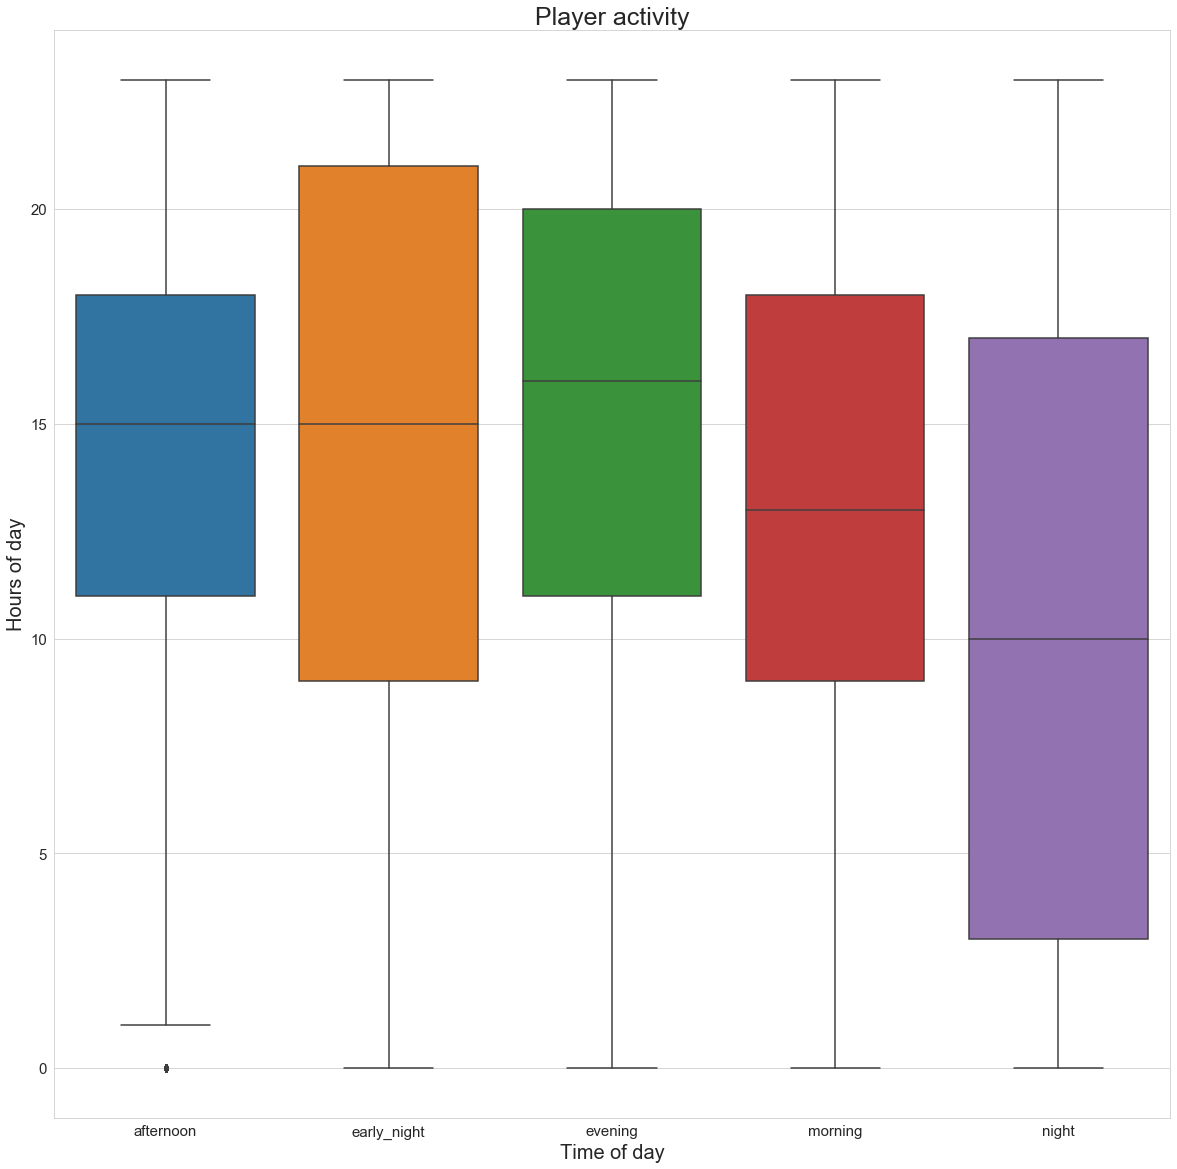

In [36]:
fig, ax = plt.subplots(figsize=(20, 20))

sns.boxplot(x=df_player["max_time_of_day"], y=df_player["hour"], ax=ax)
plt.title("Player activity", fontsize=title_fontsize)
plt.xlabel("Time of day", fontsize=axis_fontsize)
plt.ylabel("Hours of day", fontsize=axis_fontsize)
ax.tick_params(axis="both", which="major", labelsize=15)

plt.show()

TODO: evaluation of results

## 4 ELO
We computed the ELO score and consider here the top 5 players over time

In [4]:
top5_elo_df = pd.read_csv("data/processed_data/top5_elo.csv")

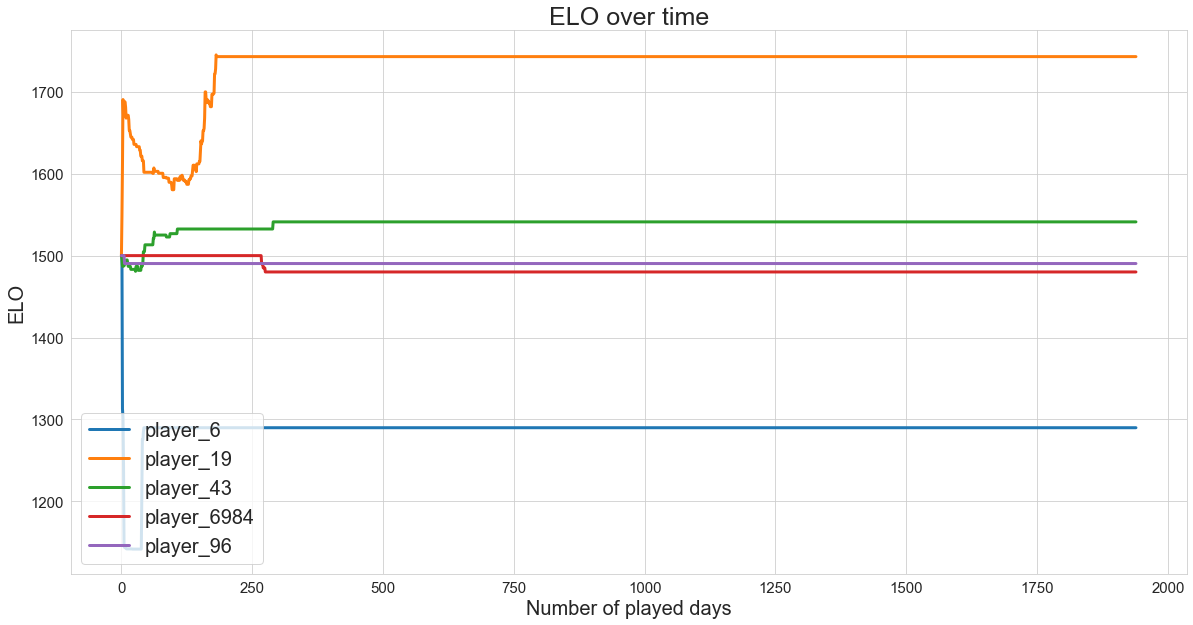

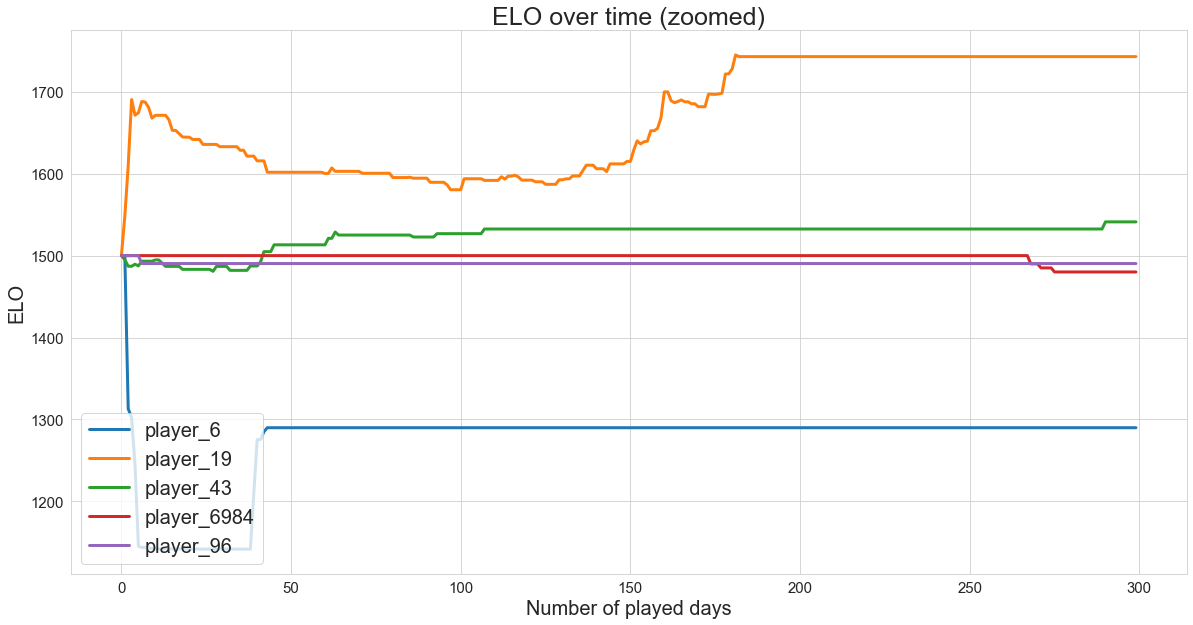

In [16]:
fig, ax = plt.subplots(figsize=(20, 10))

labels = top5_elo_df.columns
for i in range(5):
    sns.lineplot(x=top5_elo_df.index, y=top5_elo_df.iloc[:, i], label=labels[i], lw=3)
plt.title("ELO over time", fontsize=title_fontsize)
plt.xlabel("Number of played days", fontsize=axis_fontsize)
plt.ylabel("ELO", fontsize=axis_fontsize)
ax.tick_params(axis="both", which="major", labelsize=tick_label_fontsize)
ax.legend(prop={"size": legend_size})

plt.show()

# only up to day 300
fig, ax = plt.subplots(figsize=(20, 10))

for i in range(5):
    sns.lineplot(x=top5_elo_df.index[:300], y=top5_elo_df.iloc[:300, i], label=labels[i], lw=3)
plt.title("ELO over time (zoomed)", fontsize=title_fontsize)
plt.xlabel("Number of played days", fontsize=axis_fontsize)
plt.ylabel("ELO", fontsize=axis_fontsize)
ax.tick_params(axis="both", which="major", labelsize=tick_label_fontsize)
ax.legend(prop={"size": legend_size})

plt.show()

TODO: bla text